In [1]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
import os
import sys
sys.path.append('..')

from alphazero import config
import stable_rad_config

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

INFO:rdkit:Enabling RDKit 2020.03.4 jupyter extensions


In [4]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**config.dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

(965596, 7)

In [5]:
rew_df.sort_values('real_reward', ascending=False).head(10)

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index
801727,C=C(C(C)C)C(C([O])=O)(N(C)C)N(C)C,2020-10-22 11:32:51.080562,125.286545,C,84.191390,0.178097,5
697377,CCN(C)[C@@](OC)(C([O])=O)N(C)C(C)C,2020-10-22 10:54:22.618236,123.938200,C,83.308556,0.187407,4
742587,CN(O)C(=O)C(C([O])=O)(N(C)C)N(C)C,2020-10-22 11:09:10.883222,122.236010,C,79.746850,0.150217,5
868939,CC1=C[C@]1([O])N(C(C)C)C(C)(C)C,2020-10-22 12:06:42.490719,120.605890,N,78.927704,0.166436,5
697330,CCO[C@@](C([O])=O)(N(C)C)N(C)C(C)C,2020-10-22 10:54:22.027057,120.559074,C,82.196130,0.232741,3
783169,CC(=O)[C@@](C([O])=O)(N(C)C)N(C)C(C)C,2020-10-22 11:25:51.098359,120.482110,C,82.235310,0.235064,3
663351,C=C(O)[C@](C([O])=O)(N(C)C)N(C)CCC,2020-10-22 10:44:44.413717,120.424030,C,80.067890,0.192877,3
708018,C=C(C)[C@@](C([O])=O)(N(C)C)N(C)C(C)C,2020-10-22 10:57:56.041969,120.378260,C,83.819910,0.268833,3
744627,C=C(C)[C@](C([O])=O)(N(C)C)N(C)C(C)C,2020-10-22 11:10:34.069426,120.307510,C,83.008896,0.254028,3
851177,CC(C)N(C(C)(C)CO)[C@@](C)([O])N(C)C,2020-10-22 11:55:06.832184,120.216470,N,88.050660,0.356684,3


In [6]:
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG

In [7]:
from run_mcts import predict
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

def pred_bv(mol):
    _, bv = predict(
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return bv.numpy().flatten()

In [8]:
redox_model = tf.keras.models.load_model(
    '/projects/rlmolecule/pstjohn/models/20201030_redox_model/',
    compile=False)

@tf.function(experimental_relax_shapes=True)                
def predict_redox_tf(inputs):
    return redox_model.predict_step(inputs)

def pred_redox(mol):
    return predict_redox_tf(
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()}).numpy().flatten()

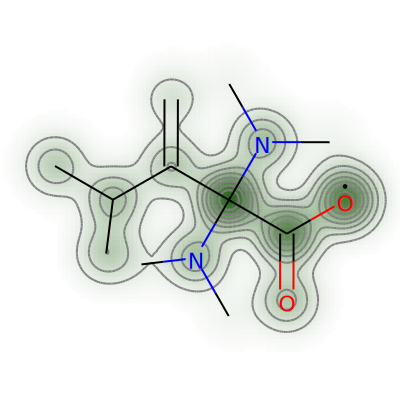

In [9]:
mol = rdkit.Chem.MolFromSmiles('C=C(C(C)C)C(C([O])=O)(N(C)C)N(C)C')

d = rdMolDraw2D.MolDraw2DSVG(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())

In [62]:
high_reward = rew_df[rew_df.real_reward > 100].copy()

In [63]:
high_reward.head()

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index
162419,CCN([C](C(=O)OOC)N(C)C)C(C)=O,2020-10-21 14:30:07.584734,100.415886,C,66.082420,0.313331,3
162643,CN(C)[C](C(=O)O)C(N(C)C)N(C)C,2020-10-21 14:30:26.975235,100.991300,C,71.888000,0.417934,3
173681,CC(C)(CO)C(=C=O)C([O])(O)O,2020-10-21 14:32:13.845958,100.827450,C,67.107310,0.325597,5
174417,[CH2]C(C)=C(C=O)C(O)(O)C(=O)C(=O)ON,2020-10-21 14:32:22.424027,100.274940,C,62.581715,0.246135,3
175614,COC1=C(S)NCCC(O)(O)N1C([O])=O,2020-10-21 14:32:52.928258,103.667230,C,62.222763,0.171111,2


In [12]:
from alphazero.preprocessor import preprocessor

redox_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(Chem.MolFromSmiles(smiles), train=False) for smiles in high_reward.smiles),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

In [64]:
predicted_redox = redox_model.predict(redox_dataset, verbose=1)
high_reward['IE'] = predicted_redox[:, 0]
high_reward['EA'] = predicted_redox[:, 1]

125/125 [==============================] - 10s 83ms/step


Text(0, 0.5, '$E_{1/2}^o$, IE (V)')

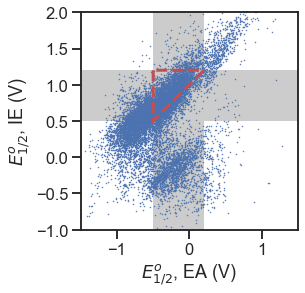

In [65]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(high_reward['EA'], high_reward['IE'], '.', ms=1)
ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

In [185]:
from tqdm import tqdm
tqdm.pandas()

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [186]:
def prepare_for_bde(smiles):

    mol = Chem.MolFromSmiles(smiles)
    radical_index = None
    for i, atom in enumerate(mol.GetAtoms()):
        if atom.GetNumRadicalElectrons() != 0:
            assert radical_index == None
            is_radical = True
            radical_index = i

            atom.SetNumExplicitHs(atom.GetNumExplicitHs() + 1)
            atom.SetNumRadicalElectrons(0)
            break

    radical_rank = Chem.CanonicalRankAtoms(mol, includeChirality=True)[radical_index]

    mol_smiles = Chem.MolToSmiles(mol)
    mol = Chem.MolFromSmiles(mol_smiles)

    radical_index_reordered = list(Chem.CanonicalRankAtoms(
        mol, includeChirality=True)).index(radical_rank)

    molH = Chem.AddHs(mol)
    for bond in molH.GetAtomWithIdx(radical_index_reordered).GetBonds():
        if 'H' in {bond.GetBeginAtom().GetSymbol(), bond.GetEndAtom().GetSymbol()}:
            bond_index = bond.GetIdx()
            break
    else:
        bond_index = None
            
    return pd.Series({
        'mol_smiles': mol_smiles,
        'radical_index_mol': radical_index_reordered,
        'bond_index': bond_index
    })


radical_bonds = high_reward.smiles.progress_apply(prepare_for_bde)

100%|██████████| 15948/15948 [00:13<00:00, 1183.99it/s]


In [252]:
def bde_check_valid(smiles):
    inputs = bde_preprocessor.construct_feature_matrices(smiles, train=False)
    return not (inputs['atom'] == 1).any() | (inputs['bond'] == 1).any()
    
is_valid = high_reward.smiles.progress_apply(bde_check_valid)
radical_bonds['is_valid'] = is_valid

100%|██████████| 15948/15948 [00:12<00:00, 1325.59it/s]


In [196]:
sys.path.append('/projects/rlmolecule/pstjohn/models/20201031_bde/')
from preprocess_inputs import preprocessor as bde_preprocessor
bde_preprocessor.from_json('/projects/rlmolecule/pstjohn/models/20201031_bde/preprocessor.json')

bde_model = tf.keras.models.load_model(
    '/projects/rlmolecule/pstjohn/models/20201031_bde/',
    compile=False)

bde_dataset = tf.data.Dataset.from_generator(
    lambda: (bde_preprocessor.construct_feature_matrices(smiles, train=False) for smiles in radical_bonds.mol_smiles),
    output_types=bde_preprocessor.output_types,
    output_shapes=bde_preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=bde_preprocessor.padded_shapes(max_bonds=100),
                  padding_values=bde_preprocessor.padding_values)

In [236]:
pred_bdes, pred_bdfes = bde_model.predict(bde_dataset, verbose=True)

125/125 [==============================] - 17s 140ms/step


In [302]:
high_reward['BDE'] = [pred_bdes[i, n][0] for i, n in enumerate(radical_bonds.bond_index)]
high_reward['V_diff'] = high_reward['IE'] - high_reward['EA']
valid_subset = high_reward[radical_bonds.is_valid & (high_reward.BDE < 80)]

Text(0, 0.5, '$E_{1/2}^o$, IE (V)')

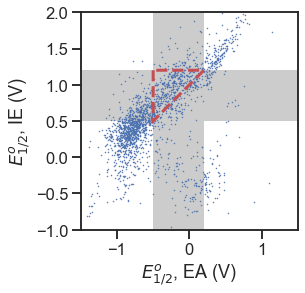

In [303]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(valid_subset['EA'], valid_subset['IE'], '.', ms=1)
ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

In [304]:
pass_gng = valid_subset[(valid_subset['EA'] > -.5) &
                        (valid_subset['IE'] < 1.2) &
                        (valid_subset['V_diff'] > 1)]

Text(0, 0.5, '$E_{1/2}^o$, IE (V)')

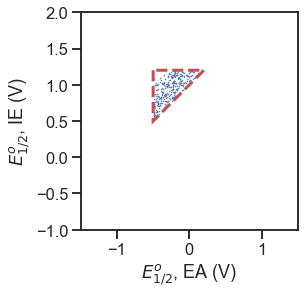

In [305]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(pass_gng['EA'], pass_gng['IE'], '.', ms=1)
ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

# ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
# ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

In [306]:
pass_gng.sort_values('real_reward', ascending=False)

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index,IE,EA,BDE,V_diff
963273,CC[C@](C)(N)C(=C(C)[CH]N)C(C)(C)CO,2020-10-22 13:29:56.343911,116.37850,C,83.146830,0.335367,5,0.577377,-0.482071,77.009911,1.059448
887248,CCC([CH]N)=C(C(=S)N(C)O)C(C)(C)C,2020-10-22 12:19:28.281769,114.85761,C,76.629930,0.235446,5,0.693352,-0.494300,74.138916,1.187652
917242,CCC([CH]N)=C(N=C(C)N)C(C)(C)CC,2020-10-22 12:46:04.813298,114.63335,C,78.437126,0.276076,5,0.619324,-0.486109,73.331879,1.105433
950901,CC[C@@](C)(C(=NN[O])C(C)(C)C)N(C)C,2020-10-22 13:16:34.459600,113.52845,C,79.562355,0.320678,4,0.994853,-0.459186,74.111565,1.454039
953099,CCN[C@@](C)(CC)C(=NN[O])C(C)(C)C,2020-10-22 13:17:57.455163,112.54984,C,76.946730,0.287938,7,0.754583,-0.407414,74.111565,1.161998
...,...,...,...,...,...,...,...,...,...,...,...
827596,C=C1OC([NH])=C(C(OC)=C(C)O)N1CC,2020-10-22 11:43:50.564810,100.04959,C,64.244880,0.283906,5,1.092268,0.062435,72.297318,1.029834
723009,CC=C(C)[C](C(O)=S)N(C)C(=O)C(=O)O,2020-10-22 11:02:31.933415,100.04594,C,64.592026,0.290922,4,0.797248,-0.422294,74.340897,1.219542
706421,[CH2]C1=C(N(C)C)C(OC)=C(O)C=C(C)N1,2020-10-22 10:57:15.308197,100.02423,C,62.405480,0.247625,2,0.826243,-0.395209,79.822220,1.221451
588555,CC1=CC([O])=C2SC(=O)C(C(C)(C)N)=C12,2020-10-22 10:27:53.150249,100.01593,C,65.603386,0.311749,9,0.747126,-0.376930,72.445312,1.124056


In [310]:
pass_gng.to_csv('20201031_gng_radicals.csv')

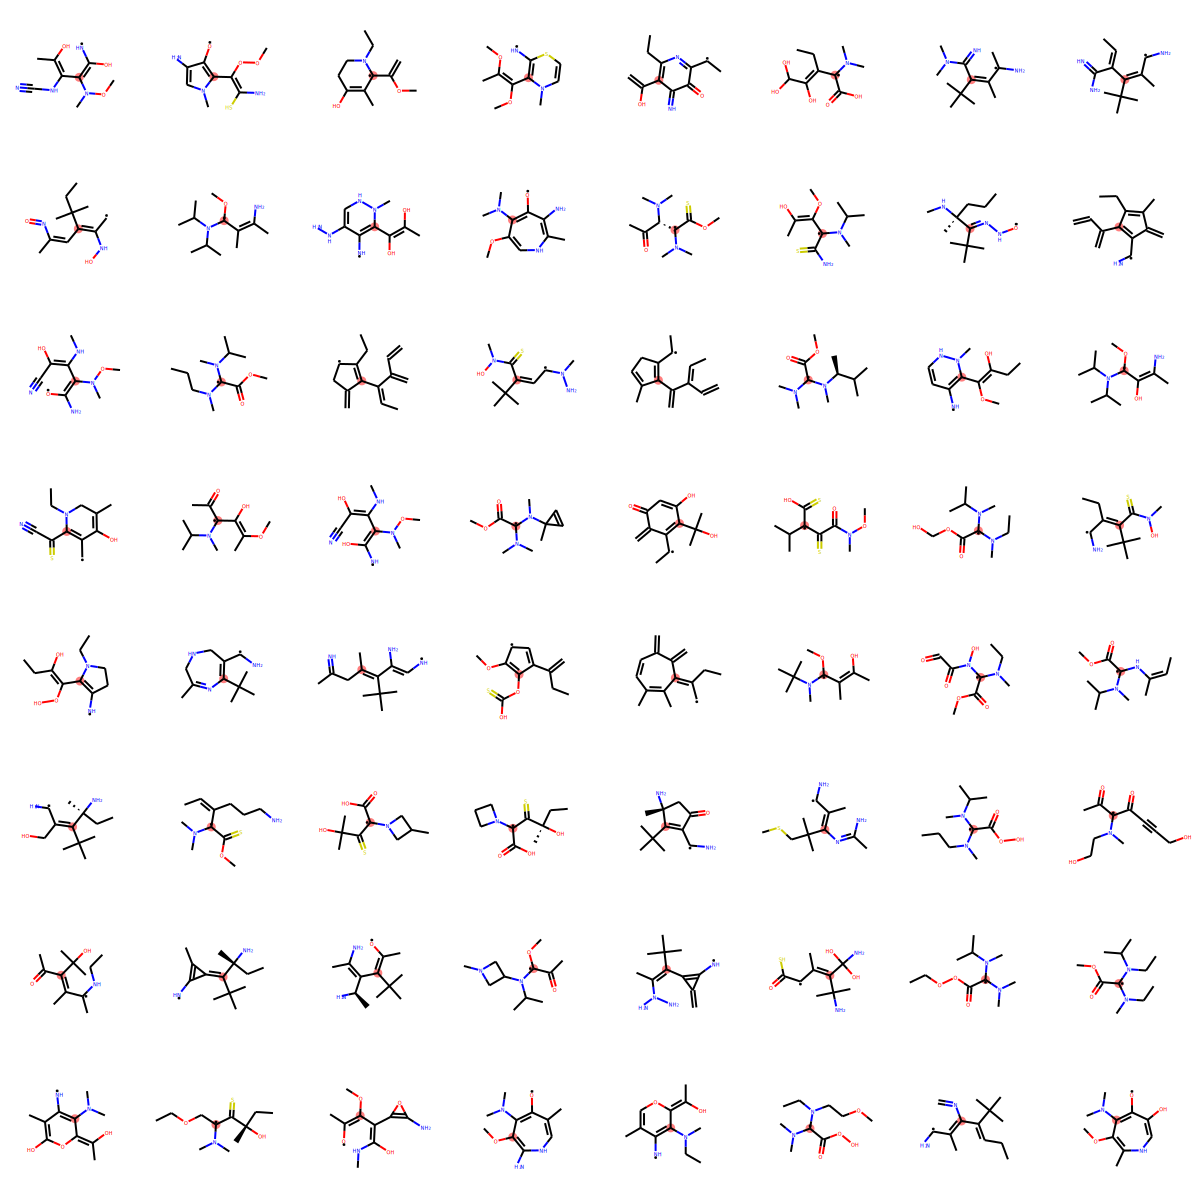

In [309]:
to_plot = pass_gng.sample(64)
d2d = rdMolDraw2D.MolDraw2DSVG(150*8, 150*8, 150, 150)
opts = d2d.drawOptions()
d2d.DrawMolecules([Chem.MolFromSmiles(row.smiles) for _, row in to_plot.iterrows()],
                  highlightAtoms=[(int(row.atom_index),) for _, row in to_plot.iterrows()])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())